# Imports

In [1]:
import os
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt


# Variables

In [2]:
BATCH_SIZE = 32
EPOCHS = 10
IMG_SIZE = (160, 160)
SEED = 42

train_dir = pathlib.Path("/Users/leonardo/Documents/Projects/cryptovision/data/processed/train")
test_dir = pathlib.Path("/Users/leonardo/Documents/Projects/cryptovision/data/processed/test")
val_dir = pathlib.Path("/Users/leonardo/Documents/Projects/cryptovision/data/processed/valid")

# Setup Dataset

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
)

Found 5789 files belonging to 57 classes.
Found 1448 files belonging to 57 classes.
Found 1810 files belonging to 57 classes.


2024-10-18 21:15:00.513371: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-10-18 21:15:00.513396: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-10-18 21:15:00.513403: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-10-18 21:15:00.513420: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-18 21:15:00.513432: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# View Some Images

In [4]:
class_names = train_ds.class_names

plt.figure(figsize=(15, 10))
#for images, labels in train_ds.take(1):
#  for i in range(9):
#    ax = plt.subplot(3, 3, i + 1)
#    plt.imshow(images[i].numpy().astype("uint8"))
#    plt.title(class_names[labels[i]])
#    plt.axis("off")

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

# AutoTune Dataset

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# Data Augmentation

In [6]:
# Data Augmentation Function
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomTranslation(0.1, 0.1),
        tf.keras.layers.RandomContrast(0.2),
        tf.keras.layers.RandomBrightness(0.2),
        #tf.keras.layers.GaussianNoise(0.2),
    ]
)

## View Augmented Images

2024-10-18 21:15:01.294981: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


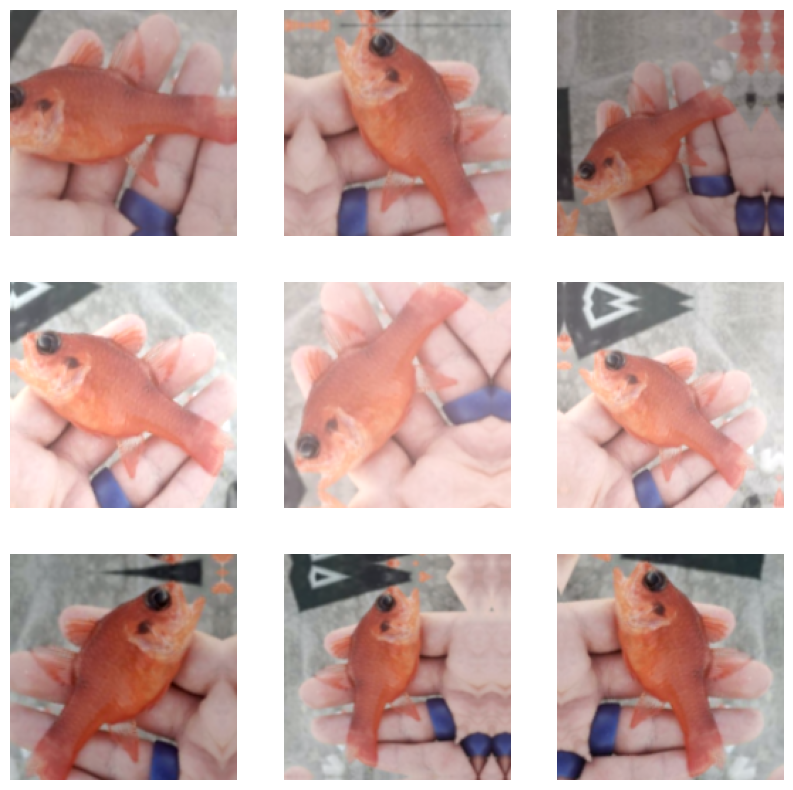

In [7]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [8]:
# MobileNetV2 Image Preprocessing
preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input

# Create Base Model
base_model = tf.keras.applications.EfficientNetV2B0(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

In [9]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [10]:
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs) 
x = preprocess_input(x) 
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(57, activation='softmax', name='output')(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 5, 5, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 57)             │        73,017 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,992,329 (22.86 MB)

 Trainable params: 73,017 (285.22 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [11]:
base_learning_rate = 0.0001
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
  loss="categorical_crossentropy", 
  metrics=['accuracy'],
)

In [12]:
loss0, accuracy0 = model.evaluate(val_ds)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

2024-10-18 21:15:04.710226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.0189 - loss: 4.1262
initial loss: 4.11
initial accuracy: 0.02


In [13]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds
)

Epoch 1/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 23s 89ms/step - accuracy: 0.0651 - loss: 3.9659 - val_accuracy: 0.2417 - val_loss: 3.3937
Epoch 2/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - accuracy: 0.2234 - loss: 3.3154 - val_accuracy: 0.3494 - val_loss: 2.9369
Epoch 3/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - accuracy: 0.3300 - loss: 2.9090 - val_accuracy: 0.4261 - val_loss: 2.6025
Epoch 4/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.4101 - loss: 2.6009 - val_accuracy: 0.4827 - val_loss: 2.3460
Epoch 5/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.4579 - loss: 2.3827 - val_accuracy: 0.5325 - val_loss: 2.1385
Epoch 6/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - accuracy: 0.5052 - loss: 2.2003 - val_accuracy: 0.5628 - val_loss: 1.9710
Epoch 7/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.5442 - loss: 2.0404 - val_accuracy: 0.5925 - val_loss: 1.8335
Epoch 8/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 16s 87ms/step - accuracy: 0.5754 - loss: 1.9094 - 

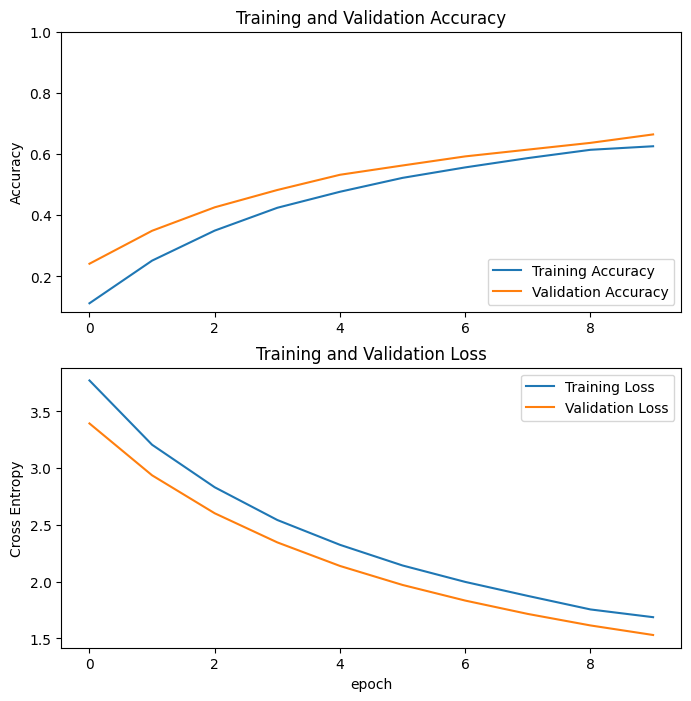

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine Tuning

In [15]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  270


In [16]:
model.compile(
  optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
  loss="categorical_crossentropy", 
  metrics=['accuracy'],
)

In [17]:
fine_tune_epochs = 10
total_epochs =  EPOCHS + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=val_ds)

Epoch 11/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 65s 247ms/step - accuracy: 0.4818 - loss: 2.5423 - val_accuracy: 0.6740 - val_loss: 1.8544
Epoch 12/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 39s 214ms/step - accuracy: 0.5667 - loss: 2.1683 - val_accuracy: 0.7072 - val_loss: 1.6148
Epoch 13/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 38s 210ms/step - accuracy: 0.6200 - loss: 1.8768 - val_accuracy: 0.7258 - val_loss: 1.4401
Epoch 14/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 37s 204ms/step - accuracy: 0.6440 - loss: 1.6766 - val_accuracy: 0.7396 - val_loss: 1.3192
Epoch 15/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 37s 204ms/step - accuracy: 0.6702 - loss: 1.5581 - val_accuracy: 0.7521 - val_loss: 1.2271
Epoch 16/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 37s 205ms/step - accuracy: 0.6862 - loss: 1.4189 - val_accuracy: 0.7597 - val_loss: 1.1464
Epoch 17/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 37s 205ms/step - accuracy: 0.7003 - loss: 1.3309 - val_accuracy: 0.7673 - val_loss: 1.0784
Epoch 18/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 37s 205ms/step - accuracy: 0.7008 -

In [18]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

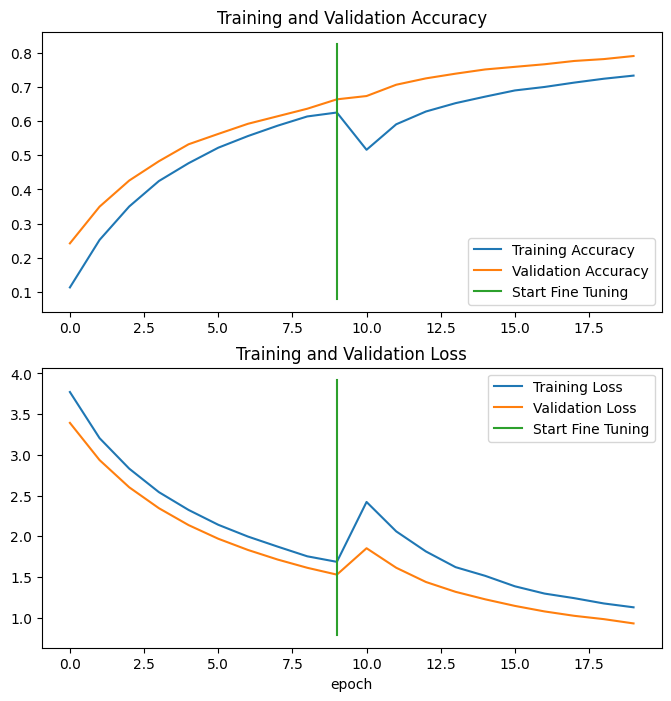

In [19]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([EPOCHS-1,EPOCHS-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([EPOCHS-1,EPOCHS-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [20]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.7877 - loss: 0.9387
Test accuracy : 0.7762430906295776
